In [1]:
# Import
import numpy as np
import matplotlib.pyplot as plt
import scipy.interpolate as inter 
import scipy.integrate as integrate
from scipy.integrate import quad, nquad
from scipy.special import ellipe
from scipy.special import ellipk

In [2]:
# Parameters for Galaxy NGC 5533
G = 4.300e-6                                                #gravitational constant (kpc/solar mass*(km/s)^2)
h = 8.9                                                     #radial scale-length (kpc)
#rho00 = 0.31e9                                              #central 3D density (solar mass/kpc^2) 
epsdisk = 5.0                                               #mass-to-light ratio disk
mu0_d = 21.27                                               # disk central surface brightness in mag arcsec^-2

z0 = lambda h: 0.2*h                                        #half-thickness (kpc)
R = lambda h: 4*h                                           #cut-off radius (kpc)
d = lambda h: 0.2*h                                         #cut-off length upper limits (kpc)

# Disk R-band photometric profile

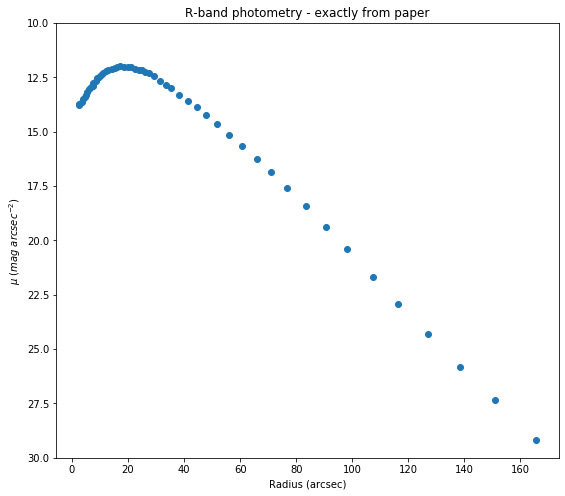

[13.7391 13.7631 13.6458 13.5177 13.4083 13.2989 13.1895 13.0587 12.9493
 12.88   12.7518 12.6825 12.5516 12.4824 12.373  12.3037 12.2318 12.1625
 12.1094 12.0588 12.0296 12.0004 12.0301 12.0384 12.0306 12.103  12.1754
 12.1863 12.2399 12.3123 12.4462 12.679  12.8717 13.003  13.316  13.6051
 13.8728 14.2234 14.6541 15.1411 15.6495 16.2355 16.8455 17.5945 18.4211
 19.3921 20.4193 21.6871 22.9149 24.2978 25.8172 27.3528 29.1853]


In [3]:
# According to Noordermeer's email: 
   # "For the contribution of the stars (bulge + disk), I used the 
   # R-band photometry published in Noordermeer & Van der Hulst (2007 - MNRAS 376; p1480). 
   # Again, I believe there was a tool (perhaps the same one as for the gas disk) 
   # in GIPSY to convert this into a rotation curve, but I'm afraid I can't recall the details."

# Used DataThief to get data from image
#mudata = np.loadtxt("../data/nord-mu-disk.txt")
mudata = np.loadtxt("../data/nord-mu.txt")
rarcsec, mu_magarcsec = mudata.T

# Plot R-band photometry to make sure data was traced right
plt.figure(figsize=(9,8))
plt.scatter(rarcsec,mu_magarcsec)
plt.title("R-band photometry - exactly from paper")
plt.xlabel("Radius (arcsec)")
plt.ylabel("$\mu$ ($mag$ $arcsec^{-2}$)")
plt.ylim(30,10)
plt.show()
print(mu_magarcsec)

[198.24803517 198.59434263 196.90176491 195.05334884 193.47476399
 191.89617915 190.3175943  188.43021864 186.85163379 185.851671
 184.00181197 183.00184918 181.11303056 180.11451072 178.53592587
 177.53596308 176.49848364 175.49852085 174.73231559 174.00218402
 173.58084328 173.15950253 173.58805802 173.70782268 173.59527275
 174.63996693 175.68466111 175.84194241 176.61536241 177.66005658
 179.59216363 182.95134601 185.73190633 187.62649674 192.14292321
 196.31448518 200.17725632 205.23623115 211.45100714 218.47816271
 225.8141091  234.26978295 243.07176427 253.87944296 265.80684911
 279.81787183 294.63983118 312.93352283 330.65003538 350.6045599
 372.52870811 394.68661385 421.12863148]
306.91498773920125


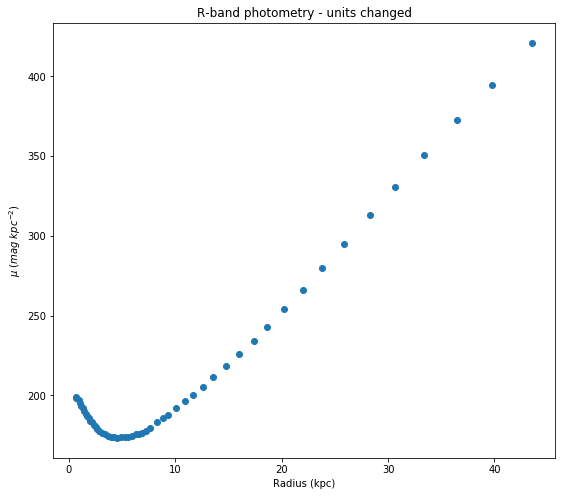

In [7]:
# Convert mag arcsec^-2 to mag kpc^-2
# First to degree: 1 degree = 3600 arcseconds
mu_degree = mu_magarcsec * 3600**2
# Then to radians: 1 radian = 180degree/Pi
mu_radians = mu_degree * (180/np.pi)**2
# Then to Mpc: 1 Mpc = 2*Pi*distance*angle(in degrees)/360degrees (source: https://www.astronomynotes.com/solarsys/s2.htm)
D = 54.3                                    # distance in Mpc
mu_Mpc = mu_radians / (D**2)
mu_kpc = mu_Mpc / (1000**2)
print(mu_kpc)

# Converting arcseconds to kpc for radius measurements
rkpc = rarcsec*D*1000/206265                # calculated using http://astro.physics.uiowa.edu/ITU/glossary/small-angle-formula/

# Convert disk central surface brightness - mag arcsec^-1 to mag kpc^-2
# First to degree: 1 degree = 3600 arcseconds
mu0d_degree = mu0_d * 3600**2
# Then to radians: 1 radian = 180degree/Pi
mu0d_radians = mu0d_degree * (180/np.pi)**2
# Then to Mpc: 1 Mpc = 2*Pi*distance*angle(in degrees)/360degrees (source: https://www.astronomynotes.com/solarsys/s2.htm)
mu0d_Mpc = mu0d_radians / (D**2)
mu0d_kpc = mu0d_Mpc / (1000**2)
print(mu0d_kpc)

# Plot R-band photometry with units changed
plt.figure(figsize=(9,8))
plt.scatter(rkpc,mu_kpc)
plt.title("R-band photometry - units changed")
plt.xlabel("Radius (kpc)")
plt.ylabel("$\mu$ ($mag$ $kpc^{-2}$)")
plt.show()

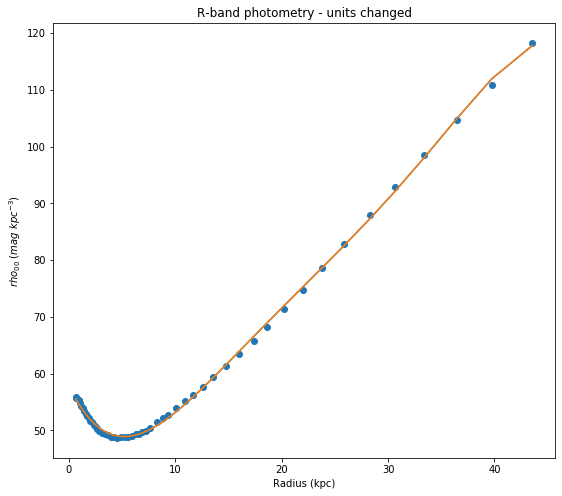

In [8]:
# rho00
z00 = 0.2*h
rho002 = mu_kpc/(2*z00)
rho00data2 = inter.UnivariateSpline(rkpc2, rho002, k=5)

# Convert univariate spline to function
def rho0function2(r):
    return rho00data2(r)

# Plot R-band photometry with units changed
plt.figure(figsize=(9,8))
plt.scatter(rkpc2,rho002)
plt.plot(rkpc2,rho00data2(rkpc2))
plt.plot(rkpc2,rho0function2(rkpc2))
plt.title("R-band photometry - units changed")
plt.xlabel("Radius (kpc)")
plt.ylabel("$rho_{00}$ ($mag$ $kpc^{-3}$)")
plt.show()

In [9]:
# Definitions
def x(r,u,xi):
    return ((r**2)+(u**2)+(xi**2))/(2*r*u)

def px(r,u,xi):
    return x(r,u,xi)-(np.sqrt((x(r,u,xi)**2)-1))

<class 'scipy.interpolate.fitpack2.LSQUnivariateSpline'>


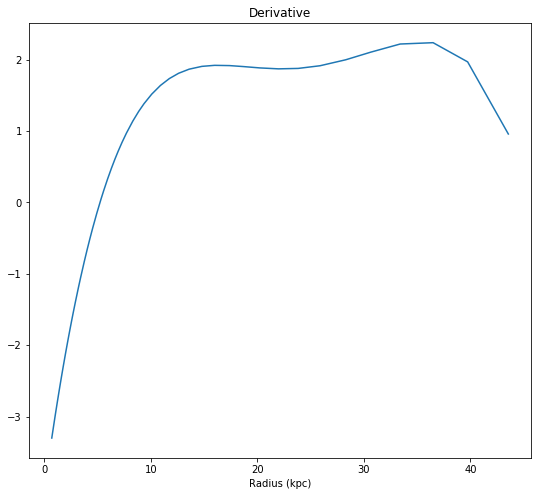

In [20]:
# Derivative of the splined traced data
drho0 = rho00data2.derivative()

# Plot Derivative
plt.figure(figsize=(9,8))
plt.plot(rkpc2,drho0(rkpc2))
plt.title("Derivative")
plt.xlabel("Radius (kpc)")
plt.ylabel("")
plt.show()

def drho0function(r):
    return drho0(r)

In [11]:
# Defining disk density distribution
def rhodata_rz(r,z,h):
    return rho0function2(r)*(np.power(np.cosh(z/z0(h)), (-2)))

def drhodata_rz(r,z,h):
    return drho0function(r)*(np.power(np.cosh(z/z0(h)), (-2)))

print(type(drho0function))

<class 'function'>


In [12]:
#complete elliptic integral
def K(r,u,xi):
    K = ellipk(px(r,u,xi)) - ellipe(px(r,u,xi))
    return K

In [13]:
#inner function
def innerfunc(r,u,z,h): 
    innerf = (2*np.sqrt(u)*K(r,u,z)*drhodata_rz(u,z,h))/(np.pi*np.sqrt(r*px(r,u,z)))
    return innerf

In [14]:
#integrate inner function
innerfunc2 = lambda z,r,u,h: innerfunc(r,u,z,h)

def innerintegral(r,u,h):
    return quad(innerfunc2, 0.1, R(h)+d(h), args=(r,u,h))[0]

In [15]:
#integrate outer function
innerintegral2 = lambda u,r,h: innerintegral(r,u,h)

def outerintegral(r,h):
    return quad(innerintegral2, 0.1, R(h)+d(h), args=(r,h))[0]

In [16]:
#Radial force
def radialforce(r,h):
    F = 4*np.pi*G*outerintegral(r,h)
    return F

In [17]:
#disk velocity
rd = np.linspace(0.1, 150, num=500)
Fv = np.vectorize(radialforce)

def d_v(r,h):
    v = np.sqrt(r*Fv(r,h))
    return v

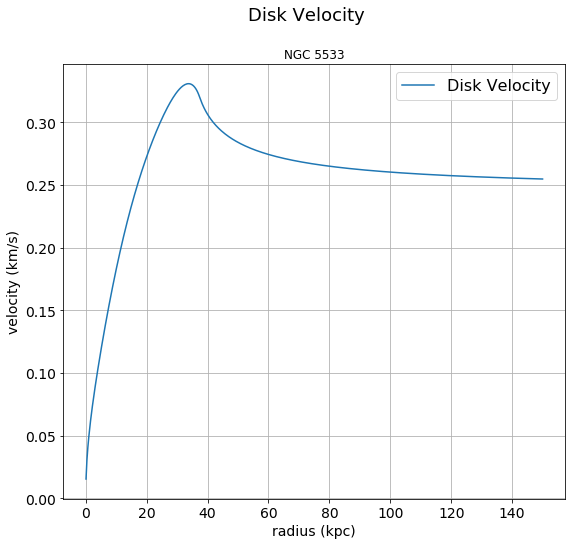

In [18]:
#plot disk velocity
fig = plt.figure(figsize=(9.0,8.0))                #size of the plot
ax = plt.axes()
ax.grid(True)
ax.yaxis.grid(True,which='minor',linestyle='--')

plt.plot(rd, d_v(rd,h), linestyle='solid', label='Disk Velocity')

plt.axis('tight');

fig.suptitle('Disk Velocity', fontsize=18)
ax.set(title='NGC 5533')              #labeling axes
#ax.set_xlim(0,100)
#ax.set_ylim(0,700)
ax.set_xlabel('radius (kpc)', fontsize=14)
ax.set_ylabel('velocity (km/s)', fontsize=14)
ax.xaxis.set_tick_params(labelsize=14)
ax.yaxis.set_tick_params(labelsize=14);

plt.legend(fontsize=16);                                   #adding legend
#plt.savefig('DiskVelocity100pts.png')
plt.show()